# İkinci El Araç Fiyat Tahmini - Preprocessing

Bu projede arabam.com'dan topladığımız ikinci el araç verilerini kullanarak fiyat tahmini yapacağız. Elimizde toplamda 21 farklı markadan yaklaşık 45.000 araç ilanı var.

**Projede kullanılan yöntemler:**
- Eksik veri analizi ve doldurma stratejileri
- Kategorik değişkenlerin encode edilmesi (One-Hot Encoding)
- Sayısal değişkenlerin ölçeklendirilmesi (StandardScaler)
- Aykırı değer tespiti ve sınırlandırılması (IQR yöntemi)
- Dört farklı model ile karşılaştırma (Linear Regression, Gradient Boosting ,Random Forest, Neural Network)

## 1. Kütüphanelerin Yüklenmesi

In [3]:
import pandas as pd
import numpy as np
import glob
import re
import os
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

# Sklearn - Veri İşleme
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Sklearn - Modeller
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Sklearn - Metrikler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential

# Görselleştirme
import matplotlib.pyplot as plt



print("Kütüphaneler yüklendi")

Kütüphaneler yüklendi


## 2. Veri Setinin Yüklenmesi

Google Drive'da tuttuğumuz JSON dosyalarını okuyoruz. Her marka için ayrı bir dosya var (car_data_bmw.json, car_data_audi.json gibi). Tüm dosyaları birleştirip tek bir DataFrame oluşturuyoruz.


In [5]:
# Klasördeki tüm car_data.json dosyalarını bul
def retrieve_database():
  json_files = glob.glob('../Data/*.json')

  print(f"Bulunan JSON dosyaları: {len(json_files)} adet")
  for f in json_files:
      print(f" {f}")

  # Tüm dosyaları oku ve birleştir
  print("-------------------------------------------")
  df_list = []
  for file in json_files:
      temp_df = pd.read_json(file)
      df_list.append(temp_df)
      print(f" {file}: {len(temp_df)} satır yüklendi")

  # Tek DataFrame'de birleştir
  df = pd.concat(df_list, ignore_index=True)

  print(f"\nToplam Veri Seti: {len(df)} satır, {len(df.columns)} sütun")
  print(f"Benzersiz Markalar: {df['Marka'].unique()}")
  return df

In [6]:
#Oluşturulan veri seti
df = retrieve_database()
#database i dışarı çıkartmak için
#df.to_excel("car-database.xlsx")



Bulunan JSON dosyaları: 21 adet
 ../Data\car_data_audi.json
 ../Data\car_data_bmw.json
 ../Data\car_data_chevrolet.json
 ../Data\car_data_citroen.json
 ../Data\car_data_dacia.json
 ../Data\car_data_fiat.json
 ../Data\car_data_ford.json
 ../Data\car_data_honda.json
 ../Data\car_data_hyundai.json
 ../Data\car_data_kia.json
 ../Data\car_data_mercedes-benz.json
 ../Data\car_data_nissan.json
 ../Data\car_data_opel.json
 ../Data\car_data_peugeot.json
 ../Data\car_data_renault.json
 ../Data\car_data_seat.json
 ../Data\car_data_skoda.json
 ../Data\car_data_tofas.json
 ../Data\car_data_toyota.json
 ../Data\car_data_volkswagen.json
 ../Data\car_data_volvo.json
-------------------------------------------
 ../Data\car_data_audi.json: 2500 satır yüklendi
 ../Data\car_data_bmw.json: 2499 satır yüklendi
 ../Data\car_data_chevrolet.json: 1900 satır yüklendi
 ../Data\car_data_citroen.json: 2500 satır yüklendi
 ../Data\car_data_dacia.json: 1775 satır yüklendi
 ../Data\car_data_fiat.json: 2475 satır yükl

In [7]:
print("--- İLK 3 SATIR ---")
df.head(3)


--- İLK 3 SATIR ---


,İlan No,İlan İsmi,İlan Konumu,İlan Tarihi,Marka,Model,Yıl,Kilometre,Renk,Garanti Durumu,...,Uzunluk,Genişlik,Yükseklik,Boş Ağırlığı,Koltuk Sayısı,Bagaj Hacmi,Ön Lastik,Aks Aralığı,Donanım Özellikleri,Link
0,29884554,2023 AUDİ A6 45TFSI QUATTRO DESİGN/MATRİX/PREM...,"Sakarya Mh. Eyüpsultan, İstanbul",12 Kasım 2025,Audi,A6 Sedan 45 TFSI Quattro Design,2023,35950,Siyah,Garantisi Yok,...,-1,-1,-1,-1,-1,-1,Yok,-1,Yok,https://www.arabam.com/ilan/galeriden-satilik-...
1,34530495,TUNÇ MOTORS | 2024 AUDİ A7 40TDİ/SLİNE/B&OLUFS...,"Merkez Mazıdağı, Mardin",17 Kasım 2025,Audi,40 TDI,2024,28000,Gri,Garantisi Yok,...,4969,1908,1422,1700,5,535,225/55 R18,2926,Yok,https://www.arabam.com/ilan/galeriden-satilik-...
2,33350594,İLK ELDEN 2020 AUDI A3 SEDAN 35 TFSI CAM TAVAN...,"Mahmutbey Mh. Bağcılar, İstanbul",08 Kasım 2025,Audi,A3 Sedan 35 TFSI Dynamic,2020,100934,Mavi,Garantisi Yok,...,-1,-1,-1,-1,-1,-1,Yok,-1,Yok,https://www.arabam.com/ilan/galeriden-satilik-...


## 3. Veri Keşfi (Exploratory Data Analysis)

Veri setimiz 45.668 satır ve 48 sütundan oluşuyor. Sütunların veri tiplerini inceleyerek hangi sütunların sayısal, hangilerin kategorik olduğunu belirliyoruz.

In [8]:
print("--- Insights From Data ---")
print(df.dtypes)
print(f"\nToplam {len(df.columns)} sütun var")
print(f"Verinin şekli {df.shape}")


--- Insights From Data ---
İlan No                        int64
İlan İsmi                     object
İlan Konumu                   object
İlan Tarihi                   object
Marka                         object
Model                         object
Yıl                            int64
Kilometre                      int64
Renk                          object
Garanti Durumu                object
Aracın ilk sahibiyim          object
Araç Türü                     object
Araç Durumu                   object
Sınıfı                        object
Satıcı                        object
Boya-değişen                  object
Takasa Uygun                  object
Plaka Uyruğu                  object
Kimden                        object
Ortalama Kasko                 int64
Ortalama Trafik Sigortası      int64
Fiyat                          int64
Vites Tipi                    object
Yakıt Tipi                    object
Kasa Tipi                     object
Çekiş                         object
Motor Hacmi

### 3.1. Eksik Veri Analizi

Veri setinde eksik değerler farklı şekillerde ifade edilmiş:
- Gerçek NaN değerleri
- Sayısal sütunlarda `-1` değeri
- Kategorik sütunlarda `"Yok"` ifadesi

Bu üç türü de tespit edip toplam eksik veri yüzdesini hesaplıyoruz.

In [9]:
# -1 ve "Yok" değerleri eksik veri anlamına geliyor
print("--- EKSİK VERİ KONTROLÜ ---")

# NaN sayısı
nan_counts = df.isnull().sum()

# -1 değeri sayısı (sayısal sütunlarda eksik veri olarak kullanılmış)
minus_one_counts = (df == -1).sum()

# "Yok" değeri sayısı (kategorik sütunlarda eksik veri olarak kullanılmış)
yok_counts = (df == "Yok").sum()

# Birleştir ve göster
missing_df = pd.DataFrame({
    'NaN': nan_counts,
    '-1': minus_one_counts,
    '"Yok"': yok_counts,
    'Toplam Eksik': nan_counts + minus_one_counts + yok_counts,
    'Eksik %': ((nan_counts + minus_one_counts + yok_counts) / len(df) * 100).round(1)
})
missing_df = missing_df[missing_df['Toplam Eksik'] > 0].sort_values('Eksik %', ascending=False)

print(missing_df)
# %50 üzerinde eksik veri içeren sütunlar silineblir


--- EKSİK VERİ KONTROLÜ ---
                           NaN     -1  "Yok"  Toplam Eksik  Eksik %
Ortalama Kasko               0  22528      0         22528     49.3
Ortalama Trafik Sigortası    0  18056      0         18056     39.5
Donanım Özellikleri          0      0  16198         16198     35.5
Maksimum Güç                 0  15656      0         15656     34.3
Minimum Güç                  0  15673      0         15673     34.3
Şehir Dışı Yakıt Tüketimi    0  15560      0         15560     34.1
Şehir İçi Yakıt Tüketimi     0  15561      0         15561     34.1
Ortalama Yakıt Tüketimi      0  14498      0         14498     31.7
Garanti Durumu               0      0  14349         14349     31.4
Hızlanma (0-100)             0  13531      0         13531     29.6
Bagaj Hacmi                  0  13312      0         13312     29.1
Maksimum Hız                 0  13233      0         13233     29.0
Boş Ağırlığı                 0  12944      0         12944     28.3
Takasa Uygun        

### 3.2. Kategorik Değişken Analizi

One-Hot Encoding yapacağımız için kategorik sütunların benzersiz değer sayısı önemli. 30'dan az kategorisi olan sütunlar One-Hot için uygun, fazla olanlar için Target Encoding veya silme düşünülmeli.

In [10]:
print("--- KATEGORİK DEĞİŞKEN ANALİZİ ---")

# Kategorik sütunları bul (object tipinde olanlar)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# 'Donanım Özellikleri' sütunu listeler içerdiği için TypeError'a neden oluyor.
# Bu sütun daha sonra silineceği için bu analizden hariç tutulacaktır.
if 'Donanım Özellikleri' in categorical_cols:
    categorical_cols.remove('Donanım Özellikleri')

print(f"Toplam {len(categorical_cols)} kategorik sütun bulundu:\n")

for col in categorical_cols:
    unique_count = df[col].nunique()
    # Çok fazla benzersiz değer varsa One-Hot sorun yaratır
    if unique_count > 100:
        status = "ÇOK FAZLA (Target Encoding veya sil)"
    elif unique_count > 30:
        status = "FAZLA (Target Encoding düşün)"
    else:
        status = "UYGUN (One-Hot OK)"

    print(f"   {col}: {unique_count} benzersiz {status}")

print("\nOne-Hot için sorunlu sütunlar (50+ kategori):")
for col in categorical_cols:
    if df[col].nunique() > 50:
        print(f"   - {col}: {df[col].nunique()} kategoriye sahip. {df[col].nunique()} sütun oluşur")



--- KATEGORİK DEĞİŞKEN ANALİZİ ---
Toplam 24 kategorik sütun bulundu:

   İlan İsmi: 35927 benzersiz ÇOK FAZLA (Target Encoding veya sil)
   İlan Konumu: 7421 benzersiz ÇOK FAZLA (Target Encoding veya sil)
   İlan Tarihi: 147 benzersiz ÇOK FAZLA (Target Encoding veya sil)
   Marka: 22 benzersiz UYGUN (One-Hot OK)
   Model: 2783 benzersiz ÇOK FAZLA (Target Encoding veya sil)
   Renk: 25 benzersiz UYGUN (One-Hot OK)
   Garanti Durumu: 4 benzersiz UYGUN (One-Hot OK)
   Aracın ilk sahibiyim: 3 benzersiz UYGUN (One-Hot OK)
   Araç Türü: 4 benzersiz UYGUN (One-Hot OK)
   Araç Durumu: 4 benzersiz UYGUN (One-Hot OK)
   Sınıfı: 9 benzersiz UYGUN (One-Hot OK)
   Satıcı: 17673 benzersiz ÇOK FAZLA (Target Encoding veya sil)
   Boya-değişen: 87 benzersiz FAZLA (Target Encoding düşün)
   Takasa Uygun: 4 benzersiz UYGUN (One-Hot OK)
   Plaka Uyruğu: 4 benzersiz UYGUN (One-Hot OK)
   Kimden: 4 benzersiz UYGUN (One-Hot OK)
   Vites Tipi: 4 benzersiz UYGUN (One-Hot OK)
   Yakıt Tipi: 6 benzersiz UYGUN (

### 3.3. Kategorik Değişkenlerin Dağılımı

Bazı sütunlarda değerler çok dengesiz dağılmış. Örneğin "Araç Durumu" sütununda %97'den fazlası "İkinci El". Bu tür özellikler model için çok bilgi taşımıyor.

In [11]:
print("--- SEÇİLEN KATEGORİK SÜTUNLARIN BENZERSİZ DEĞERLERİ ---")

# Bazı sütunlardaki değerler çok baskın
selected_categorical_cols = [
    'Aracın ilk sahibiyim',
    'Araç Türü',
    'Araç Durumu',
    'Sınıfı',
    'Takasa Uygun',
    'Kimden',
    'Kasa Tipi',
]
for col in selected_categorical_cols:
    print(f"\n{col} (Unique Sayısı: {df[col].nunique()}):\n{df[col].unique()}")
    value_counts = df[col].value_counts(normalize=True) * 100
    for value, percentage in value_counts.items():
        print(f"   {value}: {percentage:.2f}%")



--- SEÇİLEN KATEGORİK SÜTUNLARIN BENZERSİZ DEĞERLERİ ---

Aracın ilk sahibiyim (Unique Sayısı: 3):
['İlk Sahibi Değilim' 'İlk Sahibiyim' 'Yok']
   İlk Sahibi Değilim: 95.36%
   Yok: 3.21%
   İlk Sahibiyim: 1.43%

Araç Türü (Unique Sayısı: 4):
['Bireysel' 'Yok' 'Şirket' 'Taksi']
   Bireysel: 96.55%
   Yok: 3.21%
   Şirket: 0.18%
   Taksi: 0.05%

Araç Durumu (Unique Sayısı: 4):
['İkinci El' 'Yurtdışından İthal Sıfır' 'Yok' 'Sıfır']
   İkinci El: 97.46%
   Yok: 2.47%
   Yurtdışından İthal Sıfır: 0.06%
   Sıfır: 0.00%

Sınıfı (Unique Sayısı: 9):
['Yok' 'E Segment' 'C Segment' 'D Segment' 'B Segment' 'F Segment'
 'G Segment' 'A Segment' 'K Segment']
   C Segment: 35.59%
   Yok: 26.83%
   B Segment: 21.18%
   D Segment: 11.21%
   E Segment: 3.41%
   G Segment: 0.70%
   A Segment: 0.60%
   F Segment: 0.47%
   K Segment: 0.01%

Takasa Uygun (Unique Sayısı: 4):
['Takasa Uygun' 'Takasa Uygun Değil' 'Yok' '-']
   Takasa Uygun: 50.85%
   Yok: 28.17%
   Takasa Uygun Değil: 20.18%
   -: 0.79%

Kimde

### 3.4. Sayısal Değişkenler ve Fiyat Korelasyonu

Hangi sayısal özelliklerin fiyatla ilişkili olduğunu anlamak için korelasyon analizi yapıyoruz. Güçlü korelasyona sahip değişkenler (|r| > 0.3) modelde kesinlikle kullanılmalı.

In [12]:
print("--- SAYISAL DEĞİŞKEN ANALİZİ VE FİYAT KORELASYONU ---\n")

# Sayısal sütunları bul
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# -1'leri NaN olarak kabul ederek istatistik hesapla
df_temp = df.copy()
df_temp = df_temp.replace(-1, np.nan)

print(f"Toplam {len(numeric_cols)} sayısal sütun bulundu:\n")

# Fiyat ile korelasyon hesapla
print("FİYAT İLE KORELASYON:\n")

correlations = []
for col in numeric_cols:
    if col != 'Fiyat':
        corr = df_temp[col].corr(df_temp['Fiyat'])
        if not np.isnan(corr):
            correlations.append((col, corr))

correlations.sort(key=lambda x: abs(x[1]), reverse=True)

for col, corr in correlations:
    if abs(corr) > 0.3:
        status = "GÜÇLÜ"
    elif abs(corr) > 0.1:
        status = "ORTA"
    else:
        status = "ZAYIF"


    print(f"   {col}: {corr:.3f} {status}")

print("\nYorumlama:")
print("   Pozitif korelasyon: Değer arttıkça fiyat artar")
print("   Negatif korelasyon: Değer arttıkça fiyat düşer")
print("   |0.3| = Güçlü ilişki, modelde kesinlikle kullanılmalı")
print("   |0.1| = Zayıf ilişki, model için faydasız olabilir")

--- SAYISAL DEĞİŞKEN ANALİZİ VE FİYAT KORELASYONU ---

Toplam 23 sayısal sütun bulundu:

FİYAT İLE KORELASYON:

   Ortalama Kasko: 0.474 GÜÇLÜ
   Tork: 0.399 GÜÇLÜ
   Maksimum Hız: 0.386 GÜÇLÜ
   Boş Ağırlığı: 0.383 GÜÇLÜ
   Aks Aralığı: 0.373 GÜÇLÜ
   Yıl: 0.332 GÜÇLÜ
   Genişlik: 0.306 GÜÇLÜ
   Uzunluk: 0.291 ORTA
   Hızlanma (0-100): -0.241 ORTA
   Minimum Güç: -0.219 ORTA
   Bagaj Hacmi: 0.143 ORTA
   Yakıt Deposu: 0.130 ORTA
   Silindir Sayısı: 0.101 ORTA
   Koltuk Sayısı: -0.067 ZAYIF
   Kilometre: -0.040 ZAYIF
   Şehir İçi Yakıt Tüketimi: -0.039 ZAYIF
   Yükseklik: -0.038 ZAYIF
   Ortalama Yakıt Tüketimi: -0.023 ZAYIF
   Maksimum Güç: -0.022 ZAYIF
   Ortalama Trafik Sigortası: 0.015 ZAYIF
   İlan No: -0.008 ZAYIF
   Şehir Dışı Yakıt Tüketimi: 0.007 ZAYIF

Yorumlama:
   Pozitif korelasyon: Değer arttıkça fiyat artar
   Negatif korelasyon: Değer arttıkça fiyat düşer
   |0.3| = Güçlü ilişki, modelde kesinlikle kullanılmalı
   |0.1| = Zayıf ilişki, model için faydasız olabilir


### 3.5. Sütun Karar Tablosu

Her sütun için ne yapacağımıza karar veriyoruz: SİL, ONE-HOT, TARGET ENCODING veya SAYISAL olarak işaretliyoruz.

In [13]:
print("--- SÜTUN KARAR TABLOSU ---")
print("Bu tablo hangi sütunları kullanacağımıza karar vermemize yardımcı olur\n")

# Her sütun için karar
decisions = []

for col in df.columns:
    # Eksik veri yüzdesi
    nan_pct = (df[col].isnull().sum() + (df[col] == -1).sum() + (df[col] == "Yok").sum()) / len(df) * 100

    # Benzersiz değer sayısı
    # 'Donanım Özellikleri' sütunu listeler içerdiği için TypeError'a neden oluyor.
    # Bu sütun zaten silineceği için unique_count'ı hesaplamayı atlıyoruz.
    if col == 'Donanım Özellikleri':
        unique_count = np.nan
    else:
        unique_count = df[col].nunique()

    dtype = str(df[col].dtype)

    # Karar
    if col in ['İlan No', 'Link', 'İlan İsmi', 'Satıcı', 'İlan Konumu', 'Donanım Özellikleri']:
        decision = "SİL"
        reason = "Model için anlamsız"
    elif nan_pct > 70:
        decision = "SİL"
        reason = f"Çok eksik ({nan_pct:.0f}%)"
    elif col == 'Fiyat':
        decision = "TARGET"
        reason = "Hedef değişken"

    elif col == 'Model' and not pd.isna(unique_count) and unique_count > 100:
        decision = "TARGET ENCODING"
        reason = f"Çok kategori ({int(unique_count)})"
    elif dtype == 'object' and not pd.isna(unique_count) and unique_count <= 30:
        decision = "ONE-HOT"
        reason = f"Az kategori ({int(unique_count)})"
    elif dtype == 'object' and not pd.isna(unique_count) and unique_count > 30:
        decision = "TARGET ENCODING"
        reason = f"Fazla kategori ({int(unique_count)})"
    elif 'float' in dtype or 'int' in dtype:
        decision = "SAYISAL"
        reason = "Scaling uygula"
    else:
        decision = "İNCELE"
        reason = "Manuel kontrol"

    formatted_unique_count = f"{int(unique_count)}" if not pd.isna(unique_count) else 'N/A'

    decisions.append({
        'Sütun': col,
        'Tip': dtype[:10],
        'Benzersiz': formatted_unique_count,
        'Eksik %': f"{nan_pct:.1f}",
        'Karar': decision,
        'Sebep': reason
    })

decision_df = pd.DataFrame(decisions)
print(decision_df.to_string(index=False))

print("ÖZET KARAR:")
print(f"   Silinecek: {len([d for d in decisions if 'SİL' in d['Karar']])} sütun")
print(f"   One-Hot: {len([d for d in decisions if 'ONE-HOT' in d['Karar']])} sütun")
print(f"   Target Encoding: {len([d for d in decisions if 'TARGET ENC' in d['Karar']])} sütun")
print(f"   Sayısal: {len([d for d in decisions if 'SAYISAL' in d['Karar']])} sütun")
print(f"   Target: 1 sütun (Fiyat)")

--- SÜTUN KARAR TABLOSU ---
Bu tablo hangi sütunları kullanacağımıza karar vermemize yardımcı olur

                    Sütun     Tip Benzersiz Eksik %           Karar                Sebep
                  İlan No   int64     44537     2.5             SİL  Model için anlamsız
                İlan İsmi  object     35927     2.5             SİL  Model için anlamsız
              İlan Konumu  object      7421     2.5             SİL  Model için anlamsız
              İlan Tarihi  object       147     2.5 TARGET ENCODING Fazla kategori (147)
                    Marka  object        22     2.5         ONE-HOT     Az kategori (22)
                    Model  object      2783     2.6 TARGET ENCODING  Çok kategori (2783)
                      Yıl   int64        56     2.5         SAYISAL       Scaling uygula
                Kilometre   int64      4907     2.5         SAYISAL       Scaling uygula
                     Renk  object        25     2.5         ONE-HOT     Az kategori (25)
          

## 4. Veri Temizleme

Bu aşamada gereksiz sütunları silip, eksik verileri düzenleyip, veriyi model için hazır hale getireceğiz.

In [14]:
columns_to_drop = [
    'İlan No',                    # Model için anlamsız
    'İlan İsmi',                  # Model için anlamsız
    'Link',                       # Model için anlamsız
    'Satıcı',                     # Model için anlamsız
    'Donanım Özellikleri',        # Çoğu "Yok" değeri
    'Plaka Uyruğu',               # Neredeyse hepsi aynı (TR)
    'İlan Tarihi',                # Model için anlamsız
    'Renk',                       # Model için anlamsız
    'Araç Türü',                  # Model için anlamsız
    'Araç Durumu',                # Model için anlamsız
    'Model',                      # Benzersiz çok değer var
    'Araç Durumu',                # Feature %99'dan fazla tek değere sahip(ikinci el)
    'Araç Türü',                  # Feature %99'dan fazla tek değere sahip(Bireysel)
    'Şehir Dışı Yakıt Tüketimi',  # Korelasyonu zayıf ve eksik veri fazla
    'Ortalama Trafik Sigortası',  # Korelasyonu zayıf ve eksik veri fazla
    'Maksimum Güç',               # Korelasyonu zayıf ve eksik veri fazla
    'Ortalama Yakıt Tüketimi',    # Korelasyonu zayıf ve eksik veri fazla

]

# Mevcut sütunlardan sadece var olanları sil
existing_cols = [col for col in columns_to_drop if col in df.columns]
df_cleaned = df.drop(columns=existing_cols)

print(f"\nSilinen sütunlar ({len(existing_cols)} adet):")
for col in existing_cols:
    print(f"   - {col}")

print(f"\nKalan sütun sayısı: {len(df_cleaned.columns)}")


Silinen sütunlar (17 adet):
   - İlan No
   - İlan İsmi
   - Link
   - Satıcı
   - Donanım Özellikleri
   - Plaka Uyruğu
   - İlan Tarihi
   - Renk
   - Araç Türü
   - Araç Durumu
   - Model
   - Araç Durumu
   - Araç Türü
   - Şehir Dışı Yakıt Tüketimi
   - Ortalama Trafik Sigortası
   - Maksimum Güç
   - Ortalama Yakıt Tüketimi

Kalan sütun sayısı: 33


In [15]:
for col in df_cleaned.columns:
    print(col)

İlan Konumu
Marka
Yıl
Kilometre
Garanti Durumu
Aracın ilk sahibiyim
Sınıfı
Boya-değişen
Takasa Uygun
Kimden
Ortalama Kasko
Fiyat
Vites Tipi
Yakıt Tipi
Kasa Tipi
Çekiş
Motor Hacmi
Motor Gücü
Tork
Silindir Sayısı
Minimum Güç
Hızlanma (0-100)
Maksimum Hız
Yakıt Deposu
Şehir İçi Yakıt Tüketimi
Uzunluk
Genişlik
Yükseklik
Boş Ağırlığı
Koltuk Sayısı
Bagaj Hacmi
Ön Lastik
Aks Aralığı


In [16]:
# Kasa tiplerinin sayısını kontrol et
kasa_counts = df_cleaned['Kasa Tipi'].value_counts(normalize=True)

# Yüzde 1'den az görülenleri "Diğer" olarak işaretle
threshold_percent = 0.01
small_categories = kasa_counts[kasa_counts < threshold_percent].index

df_cleaned['Kasa Tipi'] = df_cleaned['Kasa Tipi'].replace(small_categories, 'Diğer')

print(f"Kasa Tipi kategori sayısı 28'den {df_cleaned['Kasa Tipi'].nunique()} adede düşürüldü")

Kasa Tipi kategori sayısı 28'den 10 adede düşürüldü


In [17]:
# -1 ve "Yok" değerlerini NaN'a çevir

df_cleaned = df_cleaned.replace(-1, np.nan)
df_cleaned = df_cleaned.replace("Yok", np.nan)
df_cleaned = df_cleaned.replace("Belirtilmemiş", np.nan)

print("-1, 'Yok' ve 'Belirtilmemiş' değerleri NaN'a çevrildi")

# Şimdi eksik veri durumuna tekrar bakalım
missing_pct = (df_cleaned.isnull().sum() / len(df_cleaned) * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]

print("\n--- EKSİK VERİ YÜZDELERİ ---")
for col, pct in missing_pct.items():
    print(f"   {col}: %{pct:.1f}")

-1, 'Yok' ve 'Belirtilmemiş' değerleri NaN'a çevrildi

--- EKSİK VERİ YÜZDELERİ ---
   Ortalama Kasko: %49.3
   Minimum Güç: %34.3
   Şehir İçi Yakıt Tüketimi: %34.1
   Garanti Durumu: %31.4
   Hızlanma (0-100): %29.6
   Bagaj Hacmi: %29.1
   Maksimum Hız: %29.0
   Boş Ağırlığı: %28.3
   Takasa Uygun: %28.2
   Ön Lastik: %27.9
   Sınıfı: %26.8
   Yükseklik: %26.7
   Genişlik: %26.7
   Uzunluk: %26.7
   Yakıt Deposu: %26.6
   Tork: %26.5
   Aks Aralığı: %26.3
   Silindir Sayısı: %25.9
   Koltuk Sayısı: %25.6
   Boya-değişen: %18.8
   Motor Gücü: %4.6
   Motor Hacmi: %4.2
   Çekiş: %4.0
   Aracın ilk sahibiyim: %3.2
   Vites Tipi: %2.5
   Kasa Tipi: %2.5
   İlan Konumu: %2.5
   Yakıt Tipi: %2.5
   Fiyat: %2.5
   Marka: %2.5
   Kilometre: %2.5
   Kimden: %2.5
   Yıl: %2.5


### 4.1. Motor Hacmi ve Motor Gücü Dönüşümü

Bu sütunlar metin formatında gelmiş (örn: "1801 - 2000 cm3"). Regex ile sayıları çıkarıp aralık varsa ortalamasını alıyoruz.

In [18]:
def extract_numeric_value(value):

    # Karışık formattaki değerleri sayısal değere çevirir.

    # Örnekler:
    # - "1801 - 2000 cm3" → 1900.5 (ortalaması)
    # - "251 - 275 HP" → 263.0 (ortalaması)

    # NaN kontrolü
    if pd.isna(value):
        return np.nan

    # Zaten sayısal ise olduğu gibi döndür
    if isinstance(value, (int, float)):
        return float(value)

    # String ise içinden sayıları çıkar
    value_str = str(value)
    numbers = re.findall(r'[\d.]+', value_str)

    if len(numbers) >= 2:
        # Aralık varsa ortalamasını al
        return (float(numbers[0]) + float(numbers[1])) / 2
    elif len(numbers) == 1:
        # Tek sayı varsa onu döndür
        return float(numbers[0])

    return np.nan

# Motor Hacmi ve Motor Gücü sütunlarını düzelt
df_cleaned['Motor Hacmi'] = df_cleaned['Motor Hacmi'].apply(extract_numeric_value)
df_cleaned['Motor Gücü'] = df_cleaned['Motor Gücü'].apply(extract_numeric_value)

print("'Motor Hacmi' ve 'Motor Gücü' sütunları sayısal değere çevrildi")
print(f"\nMotor Hacmi örnek değerler:\n{df_cleaned['Motor Hacmi'].head(10)}")

'Motor Hacmi' ve 'Motor Gücü' sütunları sayısal değere çevrildi

Motor Hacmi örnek değerler:
0    1900.5
1    1968.0
2    1500.5
3    1500.5
4    1900.5
5    1968.0
6    1900.5
7    1390.0
8    1900.5
9    1700.5
Name: Motor Hacmi, dtype: float64


In [19]:
# -1 ve "Yok" değerleri eksik veri anlamına geliyor
print("--- EKSİK VERİ KONTROLÜ ---")

# Gerçek NaN sayısı
nan_counts = df_cleaned.isnull().sum()

# -1 değeri sayısı (sayısal sütunlarda eksik veri olarak kullanılmış)
minus_one_counts = (df_cleaned == -1).sum()

# "Yok" değeri sayısı (kategorik sütunlarda eksik veri olarak kullanılmış)
yok_counts = (df_cleaned == "Yok").sum()

# Birleştir ve göster
missing_df = pd.DataFrame({
    'NaN': nan_counts,
    '-1': minus_one_counts,
    '"Yok"': yok_counts,
    'Toplam Eksik': nan_counts + minus_one_counts + yok_counts,
    'Eksik %': ((nan_counts + minus_one_counts + yok_counts) / len(df_cleaned) * 100).round(1)
})
missing_df = missing_df[missing_df['Toplam Eksik'] > 0].sort_values('Eksik %', ascending=False)

print(missing_df)
# %50 üzerinde eksik veri içeren sütunlar silineblir.


--- EKSİK VERİ KONTROLÜ ---
                            NaN  -1  "Yok"  Toplam Eksik  Eksik %
Ortalama Kasko            22528   0      0         22528     49.3
Minimum Güç               15673   0      0         15673     34.3
Şehir İçi Yakıt Tüketimi  15561   0      0         15561     34.1
Garanti Durumu            14349   0      0         14349     31.4
Hızlanma (0-100)          13531   0      0         13531     29.6
Bagaj Hacmi               13312   0      0         13312     29.1
Maksimum Hız              13233   0      0         13233     29.0
Boş Ağırlığı              12944   0      0         12944     28.3
Takasa Uygun              12863   0      0         12863     28.2
Ön Lastik                 12750   0      0         12750     27.9
Sınıfı                    12254   0      0         12254     26.8
Genişlik                  12193   0      0         12193     26.7
Uzunluk                   12193   0      0         12193     26.7
Yükseklik                 12204   0      0      

In [20]:
def parse_boya_degisen(value):

    # Boya-değişen metnini sayısal değerlere çevirir.

    # Örnekler:
    # - "Tamamı orjinal" → (0, 0)
    # - "2 boyalı" → (2, 0)
    # - "3 boyalı, 1 değişen" → (3, 1)

    if pd.isna(value):
        return np.nan, np.nan

    value_lower = str(value).lower()

    # Orjinal araç kontrolü
    if 'orjinal' in value_lower or 'orijinal' in value_lower:
        return 0, 0

    # Boyalı ve değişen sayılarını bul
    boyali = re.search(r'(\d+)\s*boyalı', value_lower)
    degisen = re.search(r'(\d+)\s*değişen', value_lower)

    boya_count = int(boyali.group(1)) if boyali else 0
    degisen_count = int(degisen.group(1)) if degisen else 0

    return boya_count, degisen_count

# Yeni sütunları oluştur
df_cleaned[['Boya_Sayisi', 'Degisen_Sayisi']] = df_cleaned['Boya-değişen'].apply(
    lambda x: pd.Series(parse_boya_degisen(x))
)

# Eski sütunu sil
df_cleaned = df_cleaned.drop('Boya-değişen', axis=1)

print("'Boya-değişen' sütunu 'Boya_Sayisi' ve 'Degisen_Sayisi' olarak ayrıldı")
print(f"\nÖrnek değerler:")
print(df_cleaned[['Boya_Sayisi', 'Degisen_Sayisi']].head(10))

'Boya-değişen' sütunu 'Boya_Sayisi' ve 'Degisen_Sayisi' olarak ayrıldı

Örnek değerler:
   Boya_Sayisi  Degisen_Sayisi
0          0.0             0.0
1          0.0             0.0
2          8.0             0.0
3          7.0             0.0
4          5.0             2.0
5          2.0             2.0
6          4.0             1.0
7          6.0             2.0
8          0.0             0.0
9          3.0             1.0


In [21]:
duplicate_count = df_cleaned.duplicated().sum()
print(f"Tekrar eden satır sayısı: {duplicate_count}")

if duplicate_count > 0:
    df_cleaned = df_cleaned.drop_duplicates()
    print(f"{duplicate_count} adet tekrar eden satır silindi")
    print(f"Kalan satır sayısı: {len(df_cleaned)}")
else:
    print("Tekrar eden satır bulunamadı")

Tekrar eden satır sayısı: 1186
1186 adet tekrar eden satır silindi
Kalan satır sayısı: 44482


### 4.3. Aykırı Değer (Outlier) Analizi

IQR yöntemi ile aykırı değerleri tespit ediyoruz. Q1 - 1.5×IQR altında veya Q3 + 1.5×IQR üstündeki değerler aykırı kabul edilir.

In [22]:
def detect_outliers_iqr(df, column):

    # IQR yöntemi ile aykırı değerleri tespit eder.

    # outlier_count: Aykırı değer sayısı
    # lower_bound: Alt sınır
    # upper_bound: Üst sınır

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    return len(outliers), lower_bound, upper_bound


# Sayısal sütunlarda outlier kontrolü
numeric_cols = ['Yıl', 'Kilometre', 'Ortalama Kasko', 'Ortalama Trafik Sigortası',
                'Fiyat', 'Motor Hacmi', 'Motor Gücü', 'Tork', 'Silindir Sayısı',
                'Maksimum Güç', 'Minimum Güç', 'Hızlanma (0-100)', 'Maksimum Hız',
                'Yakıt Deposu', 'Ortalama Yakıt Tüketimi', 'Şehir İçi Yakıt Tüketimi',
                'Şehir Dışı Yakıt Tüketimi', 'Uzunluk', 'Genişlik', 'Yükseklik',
                'Boş Ağırlığı', 'Koltuk Sayısı', 'Bagaj Hacmi', 'Aks Aralığı',
                'Boya_Sayisi', 'Degisen_Sayisi']


print("--- AYKIRI DEĞER ANALİZİ (IQR Yöntemi) ---\n")
for col in numeric_cols:
    if col in df_cleaned.columns:
        count, lower, upper = detect_outliers_iqr(df_cleaned, col)
        print(f"{col}:")
        print(f"   Alt Sınır: {lower:,.0f} | Üst Sınır: {upper:,.0f}")
        print(f"   Aykırı Değer: {count} adet (%{count/len(df_cleaned)*100:.1f})\n")

--- AYKIRI DEĞER ANALİZİ (IQR Yöntemi) ---

Yıl:
   Alt Sınır: 1,990 | Üst Sınır: 2,034
   Aykırı Değer: 539 adet (%1.2)

Kilometre:
   Alt Sınır: -106,875 | Üst Sınır: 464,125
   Aykırı Değer: 415 adet (%0.9)

Ortalama Kasko:
   Alt Sınır: 6,146 | Üst Sınır: 30,086
   Aykırı Değer: 1130 adet (%2.5)

Fiyat:
   Alt Sınır: -772,500 | Üst Sınır: 2,447,500
   Aykırı Değer: 2284 adet (%5.1)

Motor Hacmi:
   Alt Sınır: 1,024 | Üst Sınır: 1,940
   Aykırı Değer: 5457 adet (%12.3)

Motor Gücü:
   Alt Sınır: 31 | Üst Sınır: 183
   Aykırı Değer: 2694 adet (%6.1)

Tork:
   Alt Sınır: -32 | Üst Sınır: 420
   Aykırı Değer: 474 adet (%1.1)

Silindir Sayısı:
   Alt Sınır: 4 | Üst Sınır: 4
   Aykırı Değer: 3936 adet (%8.8)

Minimum Güç:
   Alt Sınır: -1,025 | Üst Sınır: 6,375
   Aykırı Değer: 7 adet (%0.0)

Hızlanma (0-100):
   Alt Sınır: 6 | Üst Sınır: 17
   Aykırı Değer: 661 adet (%1.5)

Maksimum Hız:
   Alt Sınır: 132 | Üst Sınır: 240
   Aykırı Değer: 545 adet (%1.2)

Yakıt Deposu:
   Alt Sınır: 32 

### 4.4. Aykırı Değerlerin Sınırlandırılması (Capping)

Aykırı değerleri silmek yerine sınır değerlerine çekiyoruz. Silersek çok fazla veri kaybederiz. Örneğin 3 milyon TL'lik araç üst sınır olan 2.4 milyon TL olarak kaydedilir.

In [23]:
# Outlierları sınırla (capping) - silmek yerine sınır değerlerine çekiyoruz
# NEDEN: Silersek çok fazla veri kaybederiz
# Capping = Alt/üst sınırların dışındaki değerleri sınır değerine eşitle

def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    return df

# Fiyat ve Kilometre için capping uygula
# Yıl için uygulamıyoruz çünkü mantıklı aralıkta olmalı (2000-2025 gibi)

print("Capping uygulanıyor...")

before_fiyat = df_cleaned['Fiyat'].describe()
df_cleaned = cap_outliers(df_cleaned, 'Fiyat')
df_cleaned = cap_outliers(df_cleaned, 'Kilometre')

print("Fiyat ve Kilometre sütunlarına capping uygulandı")

# Sonucu göster
print("\nFiyat sütunu (Capping sonrası):")
print(df_cleaned['Fiyat'].describe())

Capping uygulanıyor...
Fiyat ve Kilometre sütunlarına capping uygulandı

Fiyat sütunu (Capping sonrası):
count    4.448100e+04
mean     9.057892e+05
std      6.018651e+05
min      1.000000e+04
25%      4.350000e+05
50%      7.600000e+05
75%      1.240000e+06
max      2.447500e+06
Name: Fiyat, dtype: float64


## 5. Feature Engineering

Mevcut sütunları kategorize ediyoruz: sayısal ve kategorik olarak ayırıyoruz. Ayrıca "Yıl" yerine "Araç Yaşı" hesaplıyoruz - model için daha anlamlı.

In [24]:
print("--- MEVCUT SÜTUNLAR ---")
print(df_cleaned.columns.tolist())

# Sütunları kategorize edelim
# Hedef değişken
target = 'Fiyat'

# Tarih sütunu (ilan yaşı feature'ı çıkarabiliriz)
date_col = 'İlan Tarihi'

# Sayısal sütunlar
numeric_features = ['Yıl', 'Kilometre', 'Motor Hacmi', 'Motor Gücü',
                    'Tork', 'Silindir Sayısı','Maksimum Güç','Minimum Güç',
                    'Hızlanma','Maksimum Hız','Yakıt Deposu','Ortalama Yakıt Tüketimi',
                    'Şehir İçi Yakıt Tüketimi','Şehir Dışı Yakıt Tüketimi','Uzunluk','Genişlik',
                    'Yükseklik','Boş Ağırlığı','Koltuk Sayısı','Bagaj Hacmi','Aks Aralığı',
                    'Boya_Sayisi', 'Degisen_Sayisi',]
# Sadece mevcut olanları al
numeric_features = [col for col in numeric_features if col in df_cleaned.columns]

# Kategorik sütunlar
categorical_features = ['Marka', 'Model', 'Renk', 'Garanti Durumu',
                       'Aracın ilk sahibiyim', 'Araç Türü', 'Araç Durumu',
                       'Takasa Uygun', 'Kimden', 'Vites Tipi', 'Yakıt Tipi',
                       'Kasa Tipi', 'Çekiş']
# Sadece mevcut olanları al
categorical_features = [col for col in categorical_features if col in df_cleaned.columns]

print(f"\nHedef Değişken: {target}")
print(f"\nSayısal Özellikler ({len(numeric_features)}):")
for col in numeric_features:
    print(f"   {col}")

print(f"\nKategorik Özellikler ({len(categorical_features)}):")
for col in categorical_features:
    print(f"  {col} ({df_cleaned[col].nunique()} benzersiz değer)")

--- MEVCUT SÜTUNLAR ---
['İlan Konumu', 'Marka', 'Yıl', 'Kilometre', 'Garanti Durumu', 'Aracın ilk sahibiyim', 'Sınıfı', 'Takasa Uygun', 'Kimden', 'Ortalama Kasko', 'Fiyat', 'Vites Tipi', 'Yakıt Tipi', 'Kasa Tipi', 'Çekiş', 'Motor Hacmi', 'Motor Gücü', 'Tork', 'Silindir Sayısı', 'Minimum Güç', 'Hızlanma (0-100)', 'Maksimum Hız', 'Yakıt Deposu', 'Şehir İçi Yakıt Tüketimi', 'Uzunluk', 'Genişlik', 'Yükseklik', 'Boş Ağırlığı', 'Koltuk Sayısı', 'Bagaj Hacmi', 'Ön Lastik', 'Aks Aralığı', 'Boya_Sayisi', 'Degisen_Sayisi']

Hedef Değişken: Fiyat

Sayısal Özellikler (19):
   Yıl
   Kilometre
   Motor Hacmi
   Motor Gücü
   Tork
   Silindir Sayısı
   Minimum Güç
   Maksimum Hız
   Yakıt Deposu
   Şehir İçi Yakıt Tüketimi
   Uzunluk
   Genişlik
   Yükseklik
   Boş Ağırlığı
   Koltuk Sayısı
   Bagaj Hacmi
   Aks Aralığı
   Boya_Sayisi
   Degisen_Sayisi

Kategorik Özellikler (9):
  Marka (21 benzersiz değer)
  Garanti Durumu (3 benzersiz değer)
  Aracın ilk sahibiyim (2 benzersiz değer)
  Takasa Uyg

### 5.1. Araç Yaşı Hesaplama

"2020 model" yerine "5 yaşında araç" demek model için daha anlamlı. Bu yüzden Yıl sütununu Araç Yaşına çeviriyoruz.

In [25]:
current_year = 2025
df_cleaned['Arac_Yasi'] = current_year - df_cleaned['Yıl']

# İlan Tarihi ve Yıl sütunlarını artık kullanmayacağız
df_cleaned = df_cleaned.drop(['Yıl'], axis=1)

# Yeni özellikleri numeric_features listesine ekle
numeric_features.append('Arac_Yasi')

# Yıl'ı artık kullanmayacağız
if 'Yıl' in numeric_features:
    numeric_features.remove('Yıl')

print(f"\nSayısal Özellikler ({len(numeric_features)}):")
for col in numeric_features:
    print(f"   {col}")

print(f"\nKategorik Özellikler ({len(categorical_features)}):")
for col in categorical_features:
    print(f"   {col} ({df_cleaned[col].nunique()} benzersiz değer)")


Sayısal Özellikler (19):
   Kilometre
   Motor Hacmi
   Motor Gücü
   Tork
   Silindir Sayısı
   Minimum Güç
   Maksimum Hız
   Yakıt Deposu
   Şehir İçi Yakıt Tüketimi
   Uzunluk
   Genişlik
   Yükseklik
   Boş Ağırlığı
   Koltuk Sayısı
   Bagaj Hacmi
   Aks Aralığı
   Boya_Sayisi
   Degisen_Sayisi
   Arac_Yasi

Kategorik Özellikler (9):
   Marka (21 benzersiz değer)
   Garanti Durumu (3 benzersiz değer)
   Aracın ilk sahibiyim (2 benzersiz değer)
   Takasa Uygun (3 benzersiz değer)
   Kimden (3 benzersiz değer)
   Vites Tipi (3 benzersiz değer)
   Yakıt Tipi (5 benzersiz değer)
   Kasa Tipi (9 benzersiz değer)
   Çekiş (6 benzersiz değer)


## 6. Train-Test Split ve Preprocessing

Veriyi eğitim (%80) ve test (%20) olarak ayırıyoruz.

**Neden şimdi bölüyoruz?**
- Encoding ve Scaling işlemlerinden önce bölmek gerekiyor
- Aksi halde "data leakage" (veri sızıntısı) olur
- Test verisi eğitim verisine sızar ve model gerçekte olduğundan daha iyi görünür

In [26]:
# X (features) ve y (hedef) ayır
all_features = numeric_features + categorical_features
# df_cleaned = df_cleaned.dropna() # Nan içerenler kaldırıldı :o
df_cleaned = df_cleaned.dropna(subset=['Fiyat']) # y_train içinde sadece 1 tane Nan var
X = df_cleaned[all_features]
y = df_cleaned[target]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Train-Test Split
# test_size=0.2 → %20 test, %80 eğitim
# random_state=42 → Sonuçların tekrarlanabilir olması için sabit seed
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # %20 test verisi
    random_state=42     # Tekrarlanabilirlik için
)
print(f"\nVeri bölündü:")
print(f"   Eğitim seti: {len(X_train)} satır (%80)")
print(f"   Test seti: {len(X_test)} satır (%20)")

X shape: (44481, 28)
y shape: (44481,)

Veri bölündü:
   Eğitim seti: 35584 satır (%80)
   Test seti: 8897 satır (%20)


### 6.1. Preprocessing Pipeline

sklearn'ün Pipeline ve ColumnTransformer yapıları ile veri dönüşümlerini düzenli yapıyoruz:
- **Sayısal sütunlar:** SimpleImputer (ortalama) + StandardScaler
- **Kategorik sütunlar:** SimpleImputer (en sık) + OneHotEncoder

In [27]:
# SAYISAL VERİLER İÇİN PIPELINE
# 1. Eksik değerleri ortalama ile doldur (mean imputation)
# 2. StandardScaler ile ölçekle (z-score: her değer = (x - mean) / std)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Eksik = ortalama
    ('scaler', StandardScaler())                   # Ölçeklendirme
])

# KATEGORİK VERİLER İÇİN PIPELINE
# 1. Eksik değerleri en sık görülen değer ile doldur (mode imputation)
# 2. OneHotEncoder ile sayısal yap (her kategori = ayrı sütun)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Eksik = en sık
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot
])

# TÜM DÖNÜŞÜMLER BİRLEŞTİR
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),     # Sayısal sütunlar
        ('cat', categorical_transformer, categorical_features)  # Kategorik sütunlar
    ],
    remainder='drop'  # Diğer sütunları at
)

print("Preprocessing Pipeline oluşturuldu")
print(f"\nSayısal özellikler: {numeric_features}")
print(f"Kategorik özellikler: {categorical_features}")

Preprocessing Pipeline oluşturuldu

Sayısal özellikler: ['Kilometre', 'Motor Hacmi', 'Motor Gücü', 'Tork', 'Silindir Sayısı', 'Minimum Güç', 'Maksimum Hız', 'Yakıt Deposu', 'Şehir İçi Yakıt Tüketimi', 'Uzunluk', 'Genişlik', 'Yükseklik', 'Boş Ağırlığı', 'Koltuk Sayısı', 'Bagaj Hacmi', 'Aks Aralığı', 'Boya_Sayisi', 'Degisen_Sayisi', 'Arac_Yasi']
Kategorik özellikler: ['Marka', 'Garanti Durumu', 'Aracın ilk sahibiyim', 'Takasa Uygun', 'Kimden', 'Vites Tipi', 'Yakıt Tipi', 'Kasa Tipi', 'Çekiş']


In [28]:
# EĞİTİM VERİSİNİ DÖNÜŞTÜR
# fit_transform: Önce istatistikleri öğren (fit), sonra dönüştür (transform)
# İstatistikler = ortalama, standart sapma, kategori listesi vb.
X_train_processed = preprocessor.fit_transform(X_train)

# TEST VERİSİNİ DÖNÜŞTÜR
# transform: Sadece dönüştür, yeni istatistik öğrenme
# Eğitim verisinden öğrenilen değerleri kullan
X_test_processed = preprocessor.transform(X_test)

print(f"\nEğitim verisi shape: {X_train_processed.shape}")
print(f"Test verisi shape: {X_test_processed.shape}")
print(f"\nToplam feature sayısı: {X_train_processed.shape[1]}")
print(f"One-Hot Encoding sonrası kategorik özellikler çok fazla oldu")


Eğitim verisi shape: (35584, 74)
Test verisi shape: (8897, 74)

Toplam feature sayısı: 74
One-Hot Encoding sonrası kategorik özellikler çok fazla oldu


### 6.2. İşlenmiş Verinin Kontrolü

Veriler artık 0 civarında ortalamalı ve standartlaştırılmış durumda. Kategorik değerler 0/1 formatına (one-hot) dönüştürüldü.

In [29]:
print("--- İŞLENMİŞ VERİ (İlk 5 satır) ---")
print(X_train_processed[:5])

print("\nVeriler artık 0 civarında ortalamalı ve standartlaştırılmış durumda")
print("Kategorik değerler 0/1 formatına (one-hot) dönüştürüldü")

--- İŞLENMİŞ VERİ (İlk 5 satır) ---
[[ 3.50289666e-01  3.03559316e-01 -1.37278495e-01 -7.23247668e-01
   2.17751481e-01  1.11178615e+00 -1.08931418e-01  1.16049824e+00
   1.21104234e+00 -2.97986151e-01 -5.38321058e-01 -4.95333316e-01
  -4.18995907e-01  2.70011058e-02 -1.57850406e+00 -2.39095156e-01
  -8.66671027e-01 -6.47873147e-01  8.16057764e-01  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.000

In [30]:
os.makedirs("ProcessedData/processed", exist_ok=True)

# Preprocessor'ı kaydet yeni veri geldiğinde aynı dönüşümü uygulamak için
joblib.dump(preprocessor, 'ProcessedData/preprocessor.joblib')
# Scale edilen veriden geri dönüşüm için kaydet
# joblib.dump(y_scaler, 'ProcessedData/y_scaler.joblib')

# İşlenmiş veriyi numpy array olarak kaydet
np.save('ProcessedData/processed/X_train_processed.npy', X_train_processed)
np.save('ProcessedData/processed/X_test_processed.npy', X_test_processed)
np.save('ProcessedData/processed/y_train.npy', y_train)
np.save('ProcessedData/processed/y_test.npy', y_test)

print("\nPreprocessing tamamlandı")


Preprocessing tamamlandı


## 7. Model Eğitimi ve Karşılaştırma



### 7.1. Linear Regression

En temel regresyon yöntemi. Özelliklerin fiyatla doğrusal ilişkide olduğunu varsayıyor. Baseline model olarak kullanıyoruz - diğer modellerin bundan daha iyi olmasını bekliyoruz.

In [56]:
linear_regression = LinearRegression()
linear_regression.fit(X_train_processed, y_train)

y_pred_real = linear_regression.predict(X_test_processed)

mae_lr = mean_absolute_error(y_test, y_pred_real)
mse_lr = mean_squared_error(y_test, y_pred_real)
r2_lr = r2_score(y_test, y_pred_real)
rmse_lr = root_mean_squared_error(y_test, y_pred_real)

print("--- Linear Regression Sonuçları ---")
print(f"MAE: {mae_lr:,.0f} TL")
print(f"MSE: {mse_lr:,.0f} TL")
print(f"R2 Skoru (Başarı Oranı): {r2_lr:.4f}")
print(f"RMSE: {rmse_lr:.0f}")

--- Linear Regression Sonuçları ---
MAE: 146,672 TL
MSE: 42,618,623,247 TL
R2 Skoru (Başarı Oranı): 0.8822
RMSE: 206443


### 7.2. Random Forest Regression

Ensemble yöntemi - birden fazla karar ağacı oluşturup sonuçlarının ortalamasını alıyor. Non-linear ilişkileri yakalayabildiği için genelde Linear Regression'dan daha iyi performans gösterir.

**Hyperparameter Tuning:** RandomizedSearchCV ve GridSearchCV ile en iyi parametreleri arıyoruz.

In [57]:
#Custom evaluatio method by percentage
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

In [58]:
# Testing mean squared error
def regression_model_testing(model,X_test,y_test):
  y_pred = model.predict(X_test_processed)
  print(f"MSE: {mean_squared_error(y_pred,y_test)}")
  print(f"MAE {mean_absolute_error(y_pred,y_test)}")
  print(f"RMSE : {root_mean_squared_error(y_pred,y_test)} ")
  print(f"R^2 : {r2_score(y_pred,y_test)}")
  print(evaluate(model,X_test,y_test))


In [59]:
# Fit the initial model without giving any parameters
rfr = RandomForestRegressor(random_state=21)
rfr.fit(X_train_processed,y_train)

RandomForestRegressor(random_state=21)

In [60]:
# Custom accuracy test for model price prediction
base_accuracy = evaluate(rfr, X_test_processed, y_test)

Model Performance
Average Error: 72050.6640 degrees.
Accuracy = 89.14%.


In [61]:
regression_model_testing(rfr, X_test_processed, y_test)

MSE: 13083239559.157736
MAE 72050.66400174398
RMSE : 114381.98966252395 
R^2 : 0.9621654432330636
Model Performance
Average Error: 72050.6640 degrees.
Accuracy = 89.14%.
89.14085190660845


In [62]:
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 21,
 'verbose': 0,
 'warm_start': False}

In [63]:
param_grid = {
    'n_estimators': [100, 200, 500, 800],
    'max_depth': [None, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'max_features': [1.0, 'auto', 'sqrt'],
    'bootstrap': [True, False]
}

rfr = RandomForestRegressor(random_state=21)


rf_random = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=param_grid,
    n_iter=50,
    scoring='r2',
    cv=3,
    verbose=3,
    random_state=21,
)


rf_random.fit(X_train_processed, y_train)


print("Best Score (R2):", rf_random.best_score_)
print("Best Params:", rf_random.best_params_)

best_model = rf_random.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.960 total time=   5.9s
[CV 2/3] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.961 total time=   6.0s
[CV 3/3] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.962 total time=   5.9s
[CV 1/3] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END bootstr

In [64]:
#Accuracy test for model price prediction for Randomized CV model
base_accuracy = evaluate(rf_random, X_test_processed, y_test)

Model Performance
Average Error: 74671.9866 degrees.
Accuracy = 88.73%.


In [65]:
base_accuracy = evaluate(best_model, X_test_processed, y_test)

Model Performance
Average Error: 74671.9866 degrees.
Accuracy = 88.73%.


In [66]:
regression_model_testing(rf_random, X_test_processed, y_test)

MSE: 13552236870.866615
MAE 74671.98658414821
RMSE : 116414.07505480862 
R^2 : 0.959792672519336
Model Performance
Average Error: 74671.9866 degrees.
Accuracy = 88.73%.
88.73337272540532


In [67]:
# Testing mean squared error
y_pred = rf_random.predict(X_test_processed)
mean_squared_error(y_pred,y_test)

13552236870.866615

In [68]:
#Best model parameters
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [69]:
# Create the parameter grid based on the results of best model parameters from random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110, 120],
    'max_features': [1, 2],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [50, 100, 200]
}

rfrg  = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rfrg,param_grid=param_grid)
grid_search.fit(X_train_processed, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True],
                         'max_depth': [80, 90, 100, 110, 120],
                         'max_features': [1, 2], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [50, 100, 200]})

In [70]:
# Accuracy test for model price prediction
base_accuracy = evaluate(grid_search, X_test_processed, y_test)

Model Performance
Average Error: 83516.5654 degrees.
Accuracy = 87.09%.


In [71]:
# Testing mean squared error with Grid Search
y_pred = grid_search.predict(X_test_processed)
mean_squared_error(y_pred,y_test)

16769838274.083252

In [72]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 120,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

### 7.3. Gradient Boosting Regressor (GBR)

In [44]:
from pathlib import Path

DATA_DIR = Path("ProcessedData/processed")
ARTIFACTS_DIR = Path("/artifacts")

SEED = 42
TUNE = True
CV_FOLDS = 3
N_ITER = 30


In [45]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Dict

import inspect
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def ensure_dir(path: str | Path) -> Path:
    p = Path(path)
    p.mkdir(parents=True, exist_ok=True)
    return p


def safe_load_npy(path: str | Path) -> np.ndarray:
    """
    .npy dosyalarını güvenli şekilde yükler.
    Gerekmedikçe allow_pickle=True kullanmaz.
    """
    path = Path(path)
    try:
        return np.load(path, allow_pickle=False)
    except ValueError:
        return np.load(path, allow_pickle=True)


def regression_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """
    Regresyon metrikleri:
      - MAE
      - RMSE
      - MSE
      - R^2
    """
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    mae = float(mean_absolute_error(y_true, y_pred))

    sig = inspect.signature(mean_squared_error)
    if "squared" in sig.parameters:
        rmse = float(mean_squared_error(y_true, y_pred, squared=False))
        mse = float(mean_squared_error(y_true, y_pred, squared=True))
    else:
        mse = float(mean_squared_error(y_true, y_pred))
        rmse = float(np.sqrt(mse))

    r2 = float(r2_score(y_true, y_pred))

    return {"mae": mae, "rmse": rmse, "mse": mse, "r2": r2}


def save_json(data: dict, path: str | Path) -> None:
    path = Path(path)
    path.write_text(json.dumps(data, indent=2, ensure_ascii=False), encoding="utf-8")


def plot_predictions(y_true, y_pred, title="Predicted vs Actual"):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    plt.figure(figsize=(7, 7))
    sns.scatterplot(x=y_true, y=y_pred, s=18, alpha=0.6)

    lo = float(min(y_true.min(), y_pred.min()))
    hi = float(max(y_true.max(), y_pred.max()))
    plt.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1)

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_residuals(y_true, y_pred, title_prefix="Residuals"):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    residuals = y_true - y_pred

    plt.figure(figsize=(8, 4.5))
    sns.histplot(residuals, bins=50, kde=True)
    plt.title(f"{title_prefix} distribution")
    plt.xlabel("Residual (y_true - y_pred)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4.5))
    sns.scatterplot(x=y_pred, y=residuals, s=18, alpha=0.6)
    plt.axhline(0.0, linestyle="--", linewidth=1)
    plt.title(f"{title_prefix} vs Predicted")
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.tight_layout()
    plt.show()


X_train: (35584, 74)  X_test: (8897, 74)
y_train_gbr: (35584,)  y_test: (8897,)

=== Baseline model (default GBR) ===
Train metrics: {'mae': 102395.79482386696, 'rmse': 156252.74892035476, 'mse': 24414921545.167423, 'r2': 0.932620711451185}
Test  metrics: {'mae': 106159.84047449773, 'rmse': 162816.36626884853, 'mse': 26509169124.99184, 'r2': 0.9267121639115068}

=== RandomizedSearchCV başlıyor (scoring = neg_mean_squared_error) ===
Fitting 3 folds for each of 30 candidates, totalling 90 fits

=== Tuned model (MSE optimizasyonu) ===
Best params: {'regressor__subsample': 1.0, 'regressor__n_estimators': 800, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 5, 'regressor__learning_rate': 0.08}
CV info: {'cv_folds': 3, 'n_iter': 30, 'scoring': 'neg_mean_squared_error', 'best_cv_score_neg_mse': -13244803022.22174, 'best_cv_mse': 13244803022.22174}
Train metrics: {'mae': 63838.577372258915, 'rmse': 97446.0614932539

,rank_test_score,mean_val_mse,mean_test_score,std_test_score,param_regressor__subsample,param_regressor__n_estimators,param_regressor__min_samples_split,param_regressor__min_samples_leaf,param_regressor__max_features,param_regressor__max_depth,param_regressor__learning_rate
15,1,1.324480e+10,-1.324480e+10,5.669480e+08,1.0,800,2,2,sqrt,5,0.08
20,2,1.371973e+10,-1.371973e+10,5.966879e+08,0.6,400,2,4,None,5,0.10
24,3,1.390705e+10,-1.390705e+10,5.013685e+08,1.0,800,2,1,None,5,0.03
16,4,1.400337e+10,-1.400337e+10,4.501842e+08,0.6,1000,10,4,sqrt,5,0.05
0,5,1.426355e+10,-1.426355e+10,5.708880e+08,0.8,800,2,2,None,4,0.05
14,6,1.439476e+10,-1.439476e+10,5.950232e+08,1.0,600,5,2,log2,5,0.08
3,7,1.475764e+10,-1.475764e+10,5.753611e+08,1.0,600,10,8,sqrt,4,0.10
10,8,1.492710e+10,-1.492710e+10,5.599993e+08,1.0,800,5,2,log2,4,0.10
12,9,1.511542e+10,-1.511542e+10,6.832254e+08,0.8,1000,20,1,log2,5,0.03
29,10,1.525035e+10,-1.525035e+10,7.081519e+08,0.6,800,2,2,None,3,0.10



=== Final seçilen model: tuned ===
Final train metrics: {'mae': 63838.577372258915, 'rmse': 97446.0614932539, 'mse': 9495734900.54702, 'r2': 0.9737940643936391}
Final test  metrics: {'mae': 73344.73503362517, 'rmse': 116432.87641228718, 'mse': 13556614709.638939, 'r2': 0.9625210827215929}


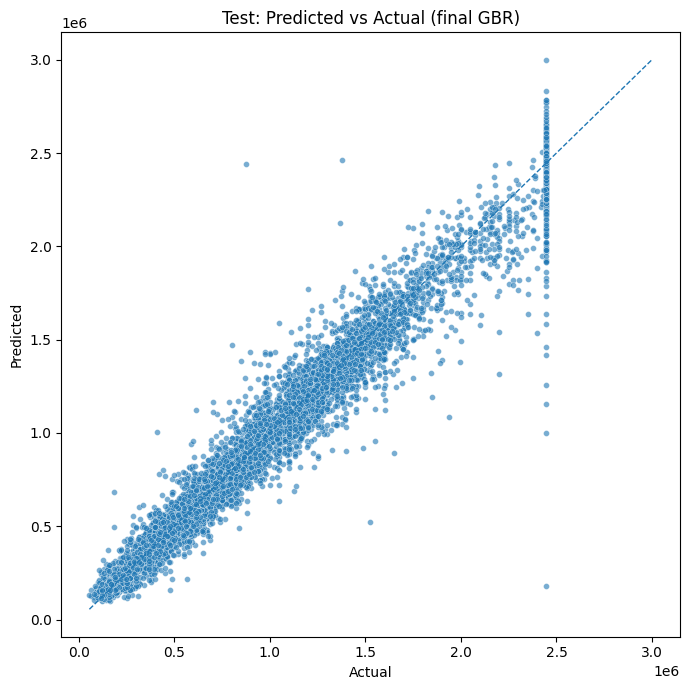

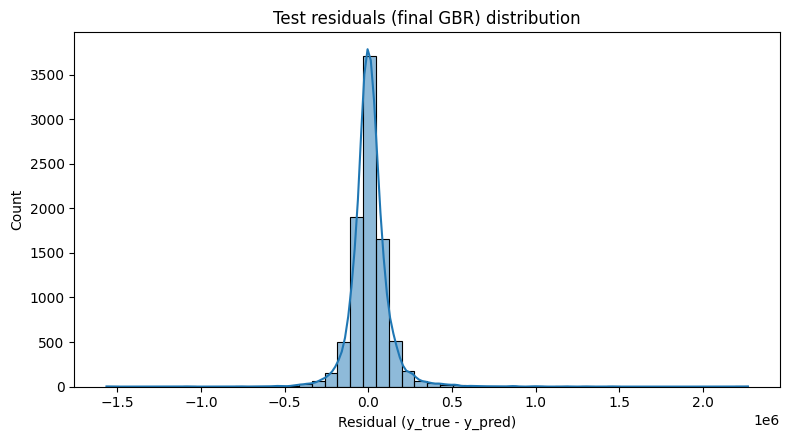

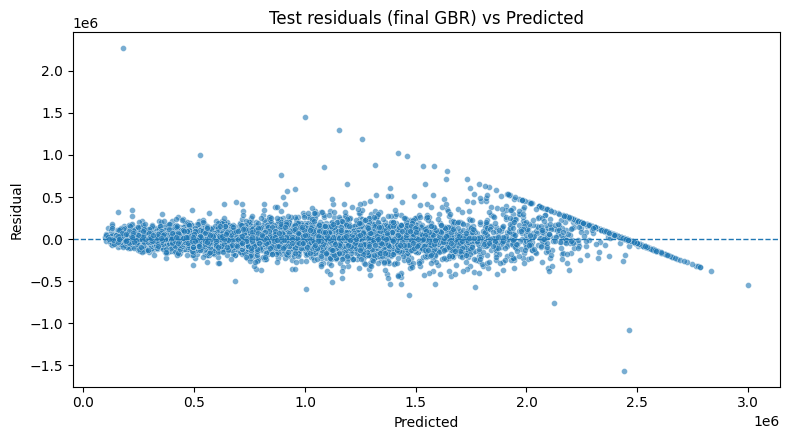

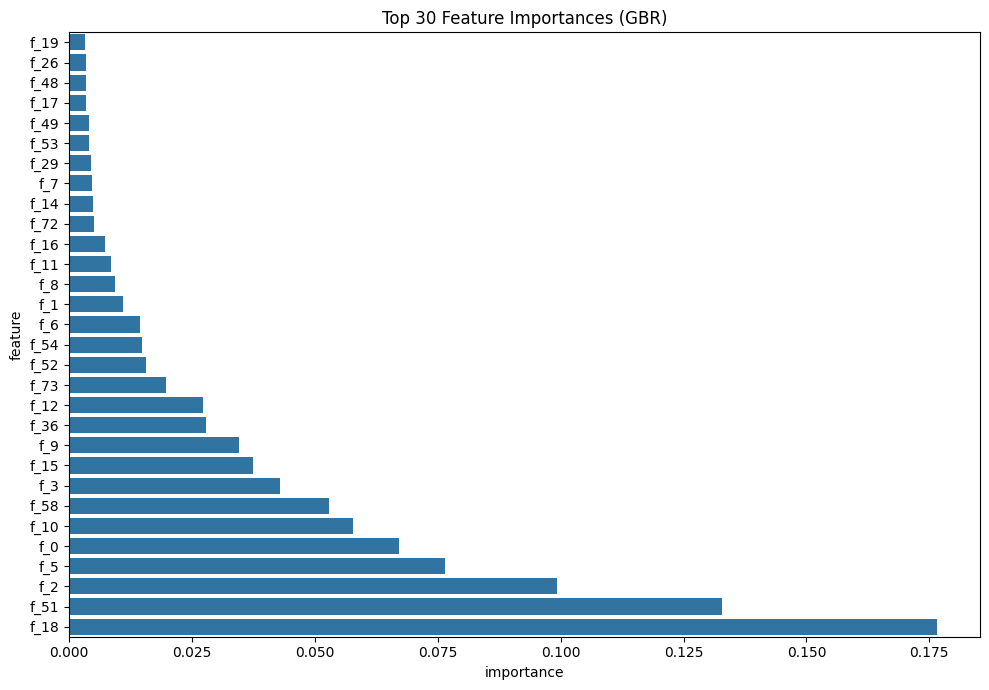


Model kaydedildi: C:\artifacts\gbr_model.joblib


In [46]:
from __future__ import annotations

from pathlib import Path

import numpy as np
import pandas as pd
from joblib import dump, load
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.compose import TransformedTargetRegressor


def maybe_wrap_log_target(regressor, y_train_gbr: np.ndarray):
    y_train_gbr = np.asarray(y_train_gbr).reshape(-1)
    if np.nanmin(y_train_gbr) > -1.0:
        return (
            TransformedTargetRegressor(
                regressor=regressor,
                func=np.log1p,
                inverse_func=np.expm1,
                check_inverse=True,
            ),
            True,
        )
    return regressor, False


def get_feature_names(preprocessor_path: Path) -> list[str] | None:
    if not preprocessor_path.exists():
        return None
    try:
        pre = load(preprocessor_path)
        if hasattr(pre, "get_feature_names_out"):
            names = pre.get_feature_names_out()
            return [str(x) for x in names]
    except Exception:
        return None
    return None


def get_inner_estimator(estimator):
    return getattr(estimator, "regressor_", estimator)


# 1) Veriyi yükleme
artifacts_dir = ensure_dir(ARTIFACTS_DIR)

X_train = safe_load_npy(DATA_DIR / "X_train_processed.npy")
X_test  = safe_load_npy(DATA_DIR / "X_test_processed.npy")
y_train_gbr = safe_load_npy(DATA_DIR / "y_train.npy").reshape(-1)
y_test  = safe_load_npy(DATA_DIR / "y_test.npy").reshape(-1)

print(f"X_train: {X_train.shape}  X_test: {X_test.shape}")
print(f"y_train_gbr: {y_train_gbr.shape}  y_test: {y_test.shape}")


# 2) Baz model + (uygunsa) log-target wrap
base = GradientBoostingRegressor(random_state=SEED)
model_template, used_log = maybe_wrap_log_target(base, y_train_gbr)

# 3) Baseline Modelin eğitilmesi ve test edilmesi
baseline_estimator = clone(model_template)
baseline_estimator.fit(X_train, y_train_gbr)

y_pred_train_baseline = baseline_estimator.predict(X_train)
y_pred_test_baseline  = baseline_estimator.predict(X_test)

baseline_train_metrics = regression_metrics(y_train_gbr, y_pred_train_baseline)
baseline_test_metrics  = regression_metrics(y_test,  y_pred_test_baseline)

print("\n=== Baseline model (default GBR) ===")
print("Train metrics:", baseline_train_metrics)
print("Test  metrics:", baseline_test_metrics)

baseline_inner = get_inner_estimator(baseline_estimator)
baseline_params = baseline_inner.get_params()


# 4) (if TUNE) Tuning Modelin Train ve Test edilmesi
tuned_estimator = None
tuned_train_metrics = None
tuned_test_metrics = None
best_params = None
cv_info = None
cv_results = None

if TUNE:
    param_dist = {
        "regressor__n_estimators": [200, 400, 600, 800, 1000],
        "regressor__learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1],
        "regressor__max_depth": [2, 3, 4, 5],
        "regressor__subsample": [0.6, 0.8, 1.0],
        "regressor__min_samples_split": [2, 5, 10, 20],
        "regressor__min_samples_leaf": [1, 2, 4, 8],
        "regressor__max_features": [None, "sqrt", "log2"],
    }

    cv = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=SEED)

    search = RandomizedSearchCV(
        estimator=clone(model_template),
        param_distributions=param_dist,
        n_iter=N_ITER,
        scoring="neg_mean_squared_error",
        cv=cv,
        random_state=SEED,
        n_jobs=-1,
        verbose=1,
    )

    print("\n=== RandomizedSearchCV başlıyor (scoring = neg_mean_squared_error) ===")
    search.fit(X_train, y_train_gbr)

    tuned_estimator = search.best_estimator_
    best_params = search.best_params_

    cv_results = pd.DataFrame(search.cv_results_)
    if "mean_test_score" in cv_results.columns:
        cv_results["mean_val_mse"] = -cv_results["mean_test_score"]

    cv_info = {
        "cv_folds": int(CV_FOLDS),
        "n_iter": int(N_ITER),
        "scoring": "neg_mean_squared_error",
        "best_cv_score_neg_mse": float(search.best_score_),
        "best_cv_mse": float(-search.best_score_),
    }

    y_pred_train_tuned = tuned_estimator.predict(X_train)
    y_pred_test_tuned  = tuned_estimator.predict(X_test)

    tuned_train_metrics = regression_metrics(y_train_gbr, y_pred_train_tuned)
    tuned_test_metrics  = regression_metrics(y_test,  y_pred_test_tuned)

    print("\n=== Tuned model (MSE optimizasyonu) ===")
    print("Best params:", best_params)
    print("CV info:", cv_info)
    print("Train metrics:", tuned_train_metrics)
    print("Test  metrics:", tuned_test_metrics)

    show_cols = [c for c in ["rank_test_score", "mean_val_mse", "mean_test_score", "std_test_score"] if c in cv_results.columns]
    param_cols = [c for c in cv_results.columns if c.startswith("param_")]
    summary_cols = show_cols + param_cols
    if summary_cols:
        display(cv_results.sort_values("rank_test_score").head(10)[summary_cols])


# 5) Final modelin seçilmesi
if tuned_estimator is not None:
    final_estimator = tuned_estimator
    final_train_metrics = tuned_train_metrics
    final_test_metrics = tuned_test_metrics
    selected_model = "tuned"
else:
    final_estimator = baseline_estimator
    final_train_metrics = baseline_train_metrics
    final_test_metrics = baseline_test_metrics
    selected_model = "baseline"

y_pred_train_final = final_estimator.predict(X_train)
y_pred_test_final  = final_estimator.predict(X_test)

print(f"\n=== Final seçilen model: {selected_model} ===")
print("Final train metrics:", final_train_metrics)
print("Final test  metrics:", final_test_metrics)

dump(final_estimator, artifacts_dir / "gbr_model.joblib")


# 6) Grafiklerin Gösterilmesi
plot_predictions(
    y_test,
    y_pred_test_final,
    title="Test: Predicted vs Actual (final GBR)",
)

plot_residuals(
    y_test,
    y_pred_test_final,
    title_prefix="Test residuals (final GBR)",
)

inner = get_inner_estimator(final_estimator)
if hasattr(inner, "feature_importances_"):
    importances = np.asarray(inner.feature_importances_, dtype=float).reshape(-1)
    feat_names = get_feature_names(DATA_DIR / "preprocessor.joblib")
    if feat_names is None or len(feat_names) != len(importances):
        feat_names = [f"f_{i}" for i in range(len(importances))]

    df_imp = pd.DataFrame({"feature": feat_names, "importance": importances})
    df_imp = df_imp.sort_values("importance", ascending=False).reset_index(drop=True)

    import matplotlib.pyplot as plt
    import seaborn as sns

    topk = df_imp.head(30).iloc[::-1]
    plt.figure(figsize=(10, 7))
    sns.barplot(data=topk, x="importance", y="feature")
    plt.title("Top 30 Feature Importances (GBR)")
    plt.tight_layout()
    plt.show()

print(f"\nModel kaydedildi: {(artifacts_dir / 'gbr_model.joblib').resolve()}")


### 7.4. Artificial Neural Network (Yapay Sinir Ağı)

In [47]:
print(tf.__version__)

2.20.0


In [48]:
car_normalizer = layers.Normalization( input_shape=[X_train_processed.shape[1],],axis=None )

car_price_model = Sequential([
    car_normalizer,
    layers.Dense(units=X_train_processed.shape[1]),
    layers.Dense(units=64,activation='relu'),
    layers.Dense(units=64, activation= 'relu'),
    layers.Dense(units=1)
])


car_price_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 74)             │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 74)             │         5,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,578 (56.95 KB)

 Trainable params: 14,575 (56.93 KB)

 Non-trainable params: 3 (16.00 B)

In [49]:
car_price_model.compile(
    optimizer= tf.optimizers.Adam(learning_rate=0.01),
    loss = 'mean_absolute_error'
)

In [50]:
history = car_price_model.fit(
    X_train_processed,
    y_train,
    epochs=300,
    validation_split=0.2
)

Epoch 1/300
890/890 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 198673.9062 - val_loss: 144282.8125
Epoch 2/300
890/890 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - loss: 118161.7500 - val_loss: 110997.6719
Epoch 3/300
890/890 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 106050.0703 - val_loss: 112390.5703
Epoch 4/300
890/890 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step - loss: 104411.0000 - val_loss: 106176.0391
Epoch 5/300
890/890 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step - loss: 104059.9844 - val_loss: 105431.2031
Epoch 6/300
890/890 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - loss: 104003.5781 - val_loss: 104458.3047
Epoch 7/300
890/890 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - loss: 103243.4844 - val_loss: 105686.0625
Epoch 8/300
890/890 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - loss: 102755.6250 - val_loss: 103902.8984
Epoch 9/300
890/890 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step - loss: 102698.6953 - val_loss: 103701.2969
Epoch 10/300
890/890 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - loss: 102155.6562 - val_loss: 105122.3359
Epoch 11/300


In [35]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
295,60765.472656,69417.898438,295
296,60977.152344,70280.078125,296
297,61216.976562,69839.945312,297
298,61219.304688,69413.312500,298
299,60991.093750,68838.976562,299


In [36]:
def plot_loss(history):
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0,150000])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

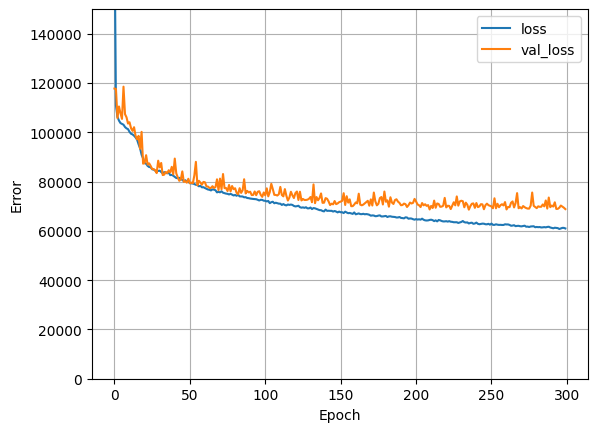

In [37]:
plot_loss(history)

In [38]:
# Evaluate the results we find

results = {}

results['test_result']=  car_price_model.evaluate(
  X_test_processed, y_test,
)



279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 70812.8203


In [39]:
print(results['test_result'])

70812.8203125


## 8. Model Kaydetme ve Deployment

Eğittiğimiz modelleri kaydediyoruz. Her seferinde yeniden eğitmek uzun zaman alır, bu yüzden modelleri diske kaydetmek önemli. Keras modeli `.keras` formatında, sklearn modelleri `joblib` ile kaydediliyor.

In [40]:
# Saving Model in Reproducable Format

# keras v3 saving the model
car_price_model.save('car_estimator.keras')

# load the saved model

loaded_model = keras.models.load_model('car_estimator.keras')
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 74)             │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 74)             │         5,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,730 (170.83 KB)

 Trainable params: 14,575 (56.93 KB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 29,152 (113.88 KB)

In [41]:
# Saving model with saving weights

car_price_model.save_weights('car_estimator_weights.weights.h5')

# You have to know how the model is structured
# The structure must exactly match the model from which weights were saved
new_model = Sequential([
    car_normalizer,
    layers.Dense(units=X_train_processed.shape[1]),
    layers.Dense(units=64,activation='relu'),
    layers.Dense(units=64, activation= 'relu'),
    layers.Dense(units=1)
])

new_model.load_weights('car_estimator_weights.weights.h5')

#Then you can compile and run it. (Also compile arguments may be needed)
new_model.compile(loss = 'mean_absolute_error')
new_model.evaluate(
  X_test_processed, y_test,
)

279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 70812.8203


70812.8203125

## Inference Efficency


In [42]:
!pip install onnxruntime skl2onnx

   ---------------------------------------- 0.0/13.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.5 MB ? eta -:--:--
    --------------------------------------- 0.3/13.5 MB ? eta -:--:--
   - -------------------------------------- 0.5/13.5 MB 1.3 MB/s eta 0:00:11
   --- ------------------------------------ 1.0/13.5 MB 1.6 MB/s eta 0:00:08
   --- ------------------------------------ 1.3/13.5 MB 1.5 MB/s eta 0:00:09
   ----- ---------------------------------- 1.8/13.5 MB 1.6 MB/s eta 0:00:08
   ------ --------------------------------- 2.1/13.5 MB 1.7 MB/s eta 0:00:07
   ------- -------------------------------- 2.6/13.5 MB 1.8 MB/s eta 0:00:07
   --------- ------------------------------ 3.1/13.5 MB 1.9 MB/s eta 0:00:06
   ---------- ----------------------------- 3.7/13.5 MB 1.9 MB/s eta 0:00:06
   ------------ --------------------------- 4.2/13.5 MB 2.0 MB/s eta 0:00:05
   -------------- ---------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 9. Model Optimizasyonu

Production ortamında hız ve boyut önemli. Bu bölümde modelleri optimize ediyoruz.



### 9.1. ONNX (Open Neural Network Exchange)

ONNX, farklı ML framework'lerinde eğitilen modelleri ortak bir formata çevirir. C++ tabanlı runtime ile çok hızlı çıkarım yapabilir. Random Forest modelimizi ONNX'e çevirip hız karşılaştırması yapıyoruz.

In [ ]:
rf_model = grid_search.best_estimator_

n_features = X_test_processed.shape[1]
initial_type = [('float_input', FloatTensorType([None, n_features]))]

onnx_model = convert_sklearn(rf_model, initial_types=initial_type)

with open("random_forest.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("Random Forest modeli ONNX formatına çevrildi.")

sess = rt.InferenceSession("random_forest.onnx", providers=['CPUExecutionProvider'])
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

input_data_onnx = X_test_processed[0:1].astype(np.float32)


#Eski model ile hızlarını karşılaştır
start_old = time.time()
pred_old = rf_model.predict(X_test_processed[0:1])
end_old = time.time()
time_old_ms = (end_old - start_old) * 1000

start_new = time.time()
pred_new = sess.run([label_name], {input_name: input_data_onnx})[0]
end_new = time.time()
time_new_ms = (end_new - start_new) * 1000

print(f"Eski Yöntem Süresi (sklearn): {time_old_ms:.4f} ms")
print(f"Yeni Yöntem Süresi (ONNX):    {time_new_ms:.4f} ms")

hizlanma_kati = time_old_ms / time_new_ms
print(f"\nHIZLANMA: {hizlanma_kati:.2f} KAT DAHA HIZLI")

print(f"\nONNX Tahmini (Scaled): {pred_new[0]}")
print(f"ONNX Çıkarım Süresi: {(end_new - start_new) * 1000:.4f} ms")

In [ ]:
# Model optimizasyonları
# Linear Regression : Baseline model olduğu için optimizasyon yapılmamıştır.
# Gradient Boosting Algoritması:
# Random Forest Algoritması : Model optimizasyonunu RandomSearch ve GridSearch kütüphaneleriyle gerçekleştirip parametre hypertuning gerçekleştirdik.
# Neural Networks: Model optimizasyonu aşağıda yer alacaktır. (Pruning, Quantization, Trade off Analysis)

### 9.2. Quantization (Niceleme)

Neural Network için TensorFlow Lite kullanarak quantization uyguluyoruz:
- Model ağırlıklarını float32'den int8'e dönüştürür
- Model boyutunu ~4 kat küçültür (203 KB → 21 KB)
- Inference süresini ~32 kat hızlandırır
- Hafif doğruluk kaybı olur (%6 civarı)

Mobil ve gömülü sistemlerde çok kullanışlı bir teknik.

In [ ]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train_processed).batch(1).take(100):
        yield [tf.dtypes.cast(input_value, tf.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(car_price_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

with open('car_price_full_int8.tflite', 'wb') as f:
    f.write(tflite_model)

print(f"Model Boyutu: {os.path.getsize('car_price_full_int8.tflite') / 1024:.2f} KB")

Saved artifact at '/tmp/tmpwcluk4ew'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 74), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140359578948176: TensorSpec(shape=(1, 1), dtype=tf.float32, name=None)
  140359578945680: TensorSpec(shape=(1, 1), dtype=tf.float32, name=None)
  140357281427344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140357281427920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140357281417936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140357281428112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140359936293584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140357281429264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140357281430608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140357281428688: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model Boyutu: 20.

In [ ]:
def predict_tflite(tflite_model_path, data):
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_scale, input_zero_point = input_details[0]['quantization']
    output_scale, output_zero_point = output_details[0]['quantization']

    predictions = []
    start_time = time.time()

    for i in range(len(data)):
        input_data = data[i:i+1].astype(np.float32)

        if input_details[0]['dtype'] == np.int8:
            input_data = (input_data / input_scale) + input_zero_point
            input_data = np.clip(input_data, -128, 127)
            input_data = input_data.astype(np.int8)

        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()

        output_data = interpreter.get_tensor(output_details[0]['index'])

        if output_details[0]['dtype'] == np.int8:
            output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale

        predictions.append(output_data[0][0])

    end_time = time.time()
    return np.array(predictions), (end_time - start_time)

start = time.time()
y_pred_orig = car_price_model.predict(X_test_processed[:100])
time_orig = time.time() - start
size_orig = os.path.getsize('car_estimator.keras') / 1024
mae_orig = mean_absolute_error(y_test[:100], y_pred_orig)

y_pred_lite, time_lite = predict_tflite('car_price_full_int8.tflite', X_test_processed[:100])
size_lite = os.path.getsize('car_price_full_int8.tflite') / 1024
mae_lite = mean_absolute_error(y_test[:100], y_pred_lite)
diff_percent = ((mae_lite - mae_orig) / mae_orig) * 100

print(f"{'Metrik'}           | {'Orijinal Model'}    | {'Optimize Model'}     | {'Kazanç/Kayıp'}\n")
print(f"{'Boyut (KB)'}       | {size_orig:.2f} KB         | {size_lite:.2f} KB           | {size_orig/size_lite:.1f}x Küçüldü")
print(f"{'Süre (100 örnek)'} | {time_orig:.4f} sn         | {time_lite:.4f} sn          | {time_orig/time_lite:.1f}x Hızlandı")
print(f"{'MAE (Hata)'}       | {mae_orig:.0f} TL          | {mae_lite:.0f} TL           | %{diff_percent:.2f} Kayıp")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Metrik           | Orijinal Model    | Optimize Model     | Kazanç/Kayıp

Boyut (KB)       | 203.68 KB         | 20.91 KB           | 9.7x Küçüldü
Süre (100 örnek) | 0.0967 sn         | 0.0030 sn          | 32.7x Hızlandı
MAE (Hata)       | 55849 TL          | 59329 TL           | %6.23 Kayıp
